#I apply my model after select top 7 features  and then copy the result in seperate notbook as requird

In [ ]:
!pip install keras scikit-learn


In [ ]:
!pip install tensorflow scikit-learn


according to paper :


  - The number of hidden neurons should be between the size of the input layer and the size of the output layer.
  - The number of hidden neurons should be 2/3 of the size of the input layer plus 2/3 of the size of the output layer.
  - The number of hidden neurons should be less than twice the size of the input layer.
  -  they used BPNN+ Batch noramlization


In [ ]:
train_x, test_x, train_y, test_y = data_split(df)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x = torch.from_numpy(train_x_scaled).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x_scaled).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

torch.Size([428, 8]) torch.Size([428])
torch.Size([108, 8]) torch.Size([108])


# Building BPNN

In [ ]:
class bpnn(nn.Module):
  def __init__(self, input, hid1, hid2, hid3, numclases):
    super(bpnn, self).__init__()
    #  y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.batch_norm1 = nn.BatchNorm1d(num_features=hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.batch_norm2 = nn.BatchNorm1d(num_features=hid2)
    self.fc3 = nn.Linear(hid2, hid3)
    self.batch_norm3 = nn.BatchNorm1d(num_features=hid3)
    self.fc4 = nn.Linear(hid3, numclass)

  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # for regularization
    x = self.batch_norm1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.batch_norm2(x)
    x = F.sigmoid(self.fc3(x))
    x = self.batch_norm3(x)
    x = F.sigmoid(self.fc4(x))
    return x

BPNNo n training data using cross-entropy loss and the Adam optimizer. It shuffles the data, processes it in batches, and updates the model weights after each batch. The accuracy and loss are calculated for both training and testing . The training stops once the test accuracy reaches 0.89 (the max acc they reach)

In [ ]:
input = train_x.shape[1]
hid1 = 64
hid2 = 32
hid3 = 16
numclass = 2
epochs = 10000
batch = 16
lrate = 0.001

modl = bpnn(input, hid1, hid2, hid3, numclass)

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(modl.parameters(), lr=lrate)

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y.shape[0]))
  source = train_x[shuffle_indices]
  target = train_y[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch]
    target_batch = target[start_i:start_i + batch]
    train_pred = modl(source_batch)
    train_pred = torch.squeeze(train_pred)
    losses = criterion(train_pred, target_batch.type(torch.LongTensor))
    optim.zero_grad()
    losses.backward()
    optim.step()

  train_pred_np = torch.argmax(train_pred, axis=1).numpy()
  train_acc = accuracy_score(target_batch, train_pred_np)

  test_pred = modl(test_x)
  test_pred = torch.squeeze(test_pred)

  test_loss = criterion(test_pred, test_y.type(torch.LongTensor))

  test_pred_np = torch.argmax(test_pred, axis=1).numpy()
  test_acc = accuracy_score(test_y, test_pred_np)

  if (epoch+1) % 50 == 0:
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(losses.item())
    test_loss_list.append(test_loss.item())
    epoch_list.append(epoch)

  if test_acc >= 0.89:
    print(f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print(f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    break

  if (epoch+1) % 100 == 0:
    print(f'Epochs [{epoch+1}/{epochs}]')
    print(f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print(f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')


Epochs [100/10000]
Training: Losses: 0.4882466197, Accuracy: 0.8125
Testing: Losses: 0.5264667273, Accuracy: 0.7685185185185185
Epochs [200/10000]
Training: Losses: 0.4386070371, Accuracy: 0.875
Testing: Losses: 0.5228557587, Accuracy: 0.7777777777777778
Epochs [300/10000]
Training: Losses: 0.4290553927, Accuracy: 0.875
Testing: Losses: 0.5157267451, Accuracy: 0.7685185185185185
Epochs [400/10000]
Training: Losses: 0.4549281597, Accuracy: 0.875
Testing: Losses: 0.4973713160, Accuracy: 0.8148148148148148
Epochs [500/10000]
Training: Losses: 0.5208695531, Accuracy: 0.75
Testing: Losses: 0.5077527761, Accuracy: 0.8055555555555556
Epochs [600/10000]
Training: Losses: 0.3255889714, Accuracy: 1.0
Testing: Losses: 0.5089549422, Accuracy: 0.7685185185185185
Epochs [700/10000]
Training: Losses: 0.3760476112, Accuracy: 0.9375
Testing: Losses: 0.5339032412, Accuracy: 0.7685185185185185
Epochs [800/10000]
Training: Losses: 0.4445284605, Accuracy: 0.875
Testing: Losses: 0.5296665430, Accuracy: 0.75

#ploting

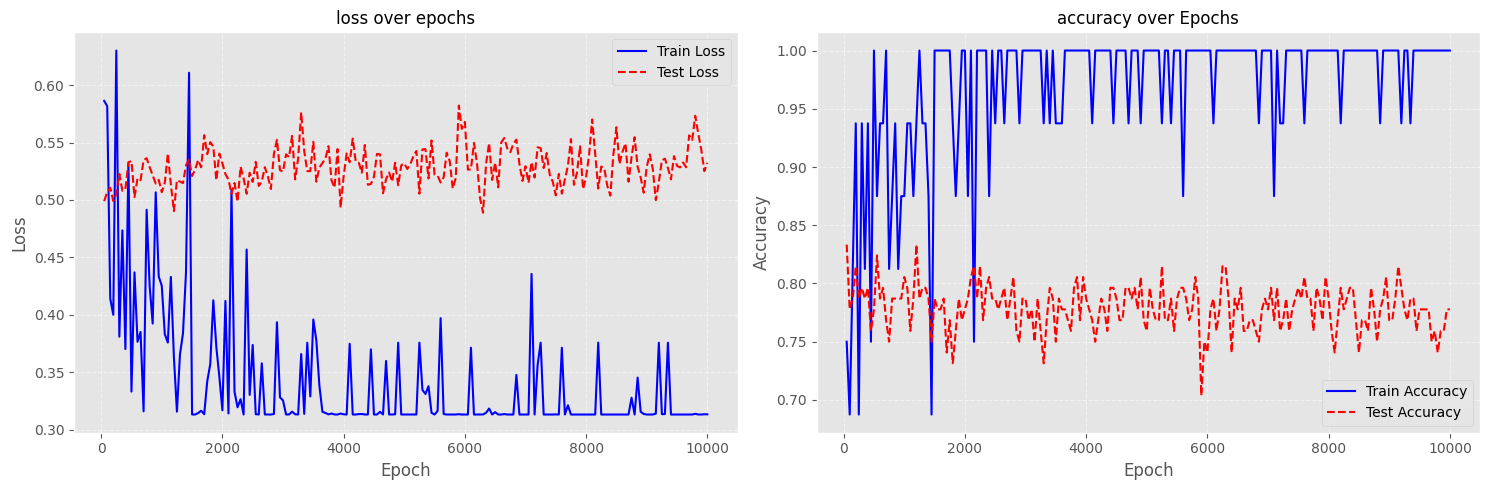

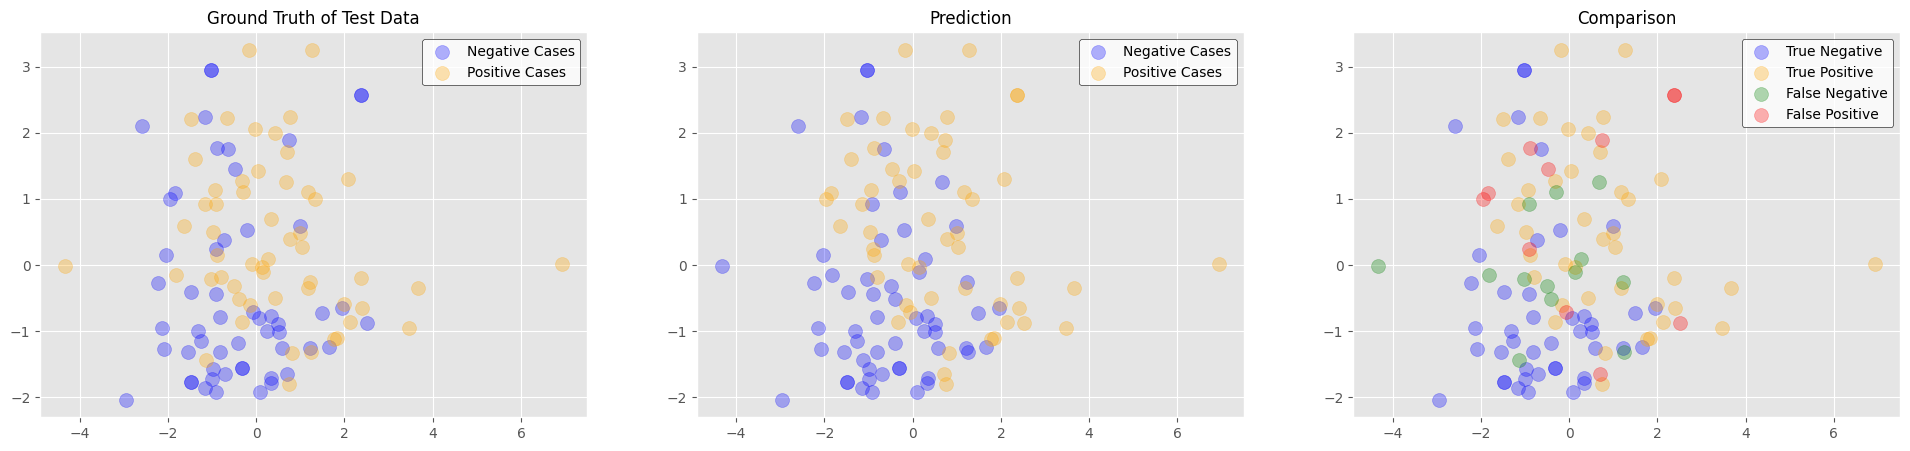

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(epoch_list, train_loss_list, 'b-', label='Train Loss')
axs[0].plot(epoch_list, test_loss_list, 'r--', label='Test Loss')
axs[0].set_title("loss over epochs", fontsize=12)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[0].legend()

axs[1].plot(epoch_list, train_acc_list, 'b-', label='Train Accuracy')
axs[1].plot(epoch_list, test_acc_list, 'r--', label='Test Accuracy')
axs[1].set_title("accuracy over Epochs", fontsize=12)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].grid(True, linestyle='--', alpha=0.5)
axs[1].legend()

plt.tight_layout()
plt.show()

pca_plot(test_x_scaled, test_y, test_pred_np, 100, 1)


In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=59e8e8ee014bd298f4c5ede868fbc45744cd5bf6341aafa848a0289e0f33943f
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


# XAI

## SHAP

  0%|          | 0/1 [00:00<?, ?it/s]

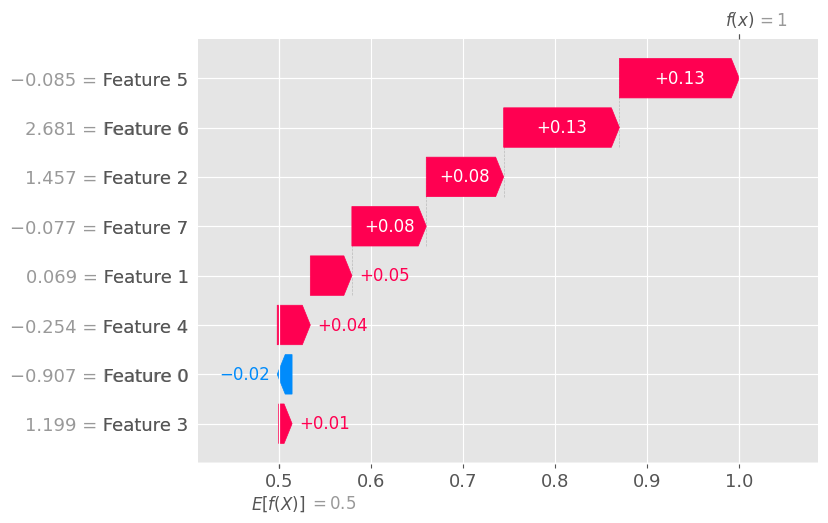

In [ ]:
import shap
import torch

def predict_proba(x_numpy):
    x_tensor = torch.from_numpy(x_numpy).float()
    with torch.no_grad():
        return modl(x_tensor).detach().numpy()

sample_idx = 10
sample_instance = test_x_scaled[sample_idx].reshape(1, -1)

modl.eval()
explainer = shap.KernelExplainer(predict_proba, train_x_scaled[:100])
explanation = explainer(sample_instance)
# access for the desired instance and class
shap_values = explanation.values[0][:,1]
shap.initjs()
# I select the first explanation for the first sample and the desired class (for examplle class 1).
shap.plots.waterfall(explanation[0][:,1])


LIME

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=train_x_scaled,
    feature_names=[f"Feature {i}" for i in range(train_x_scaled.shape[1])],
    class_names=["Class 0", "Class 1"],
    mode="classification"
)
lime_exp = lime_explainer.explain_instance(sample_instance[0], predict_proba)
lime_exp.show_in_notebook(show_table=True)